In [1]:
import os
os.chdir("../")

In [2]:
from src.entity import AgentState, get_database_schema, engine, CheckRelevance
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.config import RunnableConfig
from langchain_cohere import ChatCohere
from langgraph.graph import StateGraph, END
from src.get_current_user import get_current_user
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
def check_relevance(state: AgentState, config: RunnableConfig):
    question = state["question"]
    schema = get_database_schema(engine)
    print(f"Checking relevance of the question: {question}")
    system = """You are an assistant that determines whether a given question is related to the following database schema.

Schema:
{schema}

Respond using relevance with only "relevant" or "not_relevant".
""".format(schema=schema)
    human = f"Question: {question}"
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )
    llm = ChatCohere(model = "command-r-plus-08-2024",temperature=0)
    structured_llm = llm.with_structured_output(CheckRelevance)
    relevance_checker = check_prompt | structured_llm
    relevance = relevance_checker.invoke({})
    state["relevance"] = relevance.relevance
    print(f"Relevance determined: {state['relevance']}")
    return state

In [4]:
workflow = StateGraph(AgentState)

workflow.add_node("get_current_user", get_current_user)
workflow.add_node("check_relevance", check_relevance)
workflow.set_entry_point("get_current_user")
workflow.add_edge("get_current_user", "check_relevance")
workflow.add_edge("check_relevance", END)
app = workflow.compile()

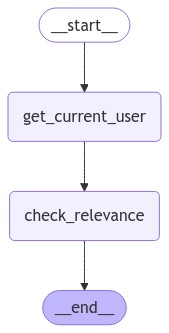

In [5]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    pass

In [6]:
config = {"configurable": {"current_user_id": "2"}}
user_question_1 = "Show me my orders"
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=config)
print("Result:", result_1['relevance'])

Retrieving the current user based on user ID.
Current user set to: User 2
Retrieved database schema.
Checking relevance of the question: Show me my orders
Relevance determined: relevant
Result: relevant
